# Classification w/ modified dataset
The model selection process is similar to that of the previous notebook, however in this attempt the dataset is different. I've added more contextual features as one-hot-encoded variables, I've removed some features that were not useful in differentiating between attack and normal data, and have incorporated standard scaling for the numeric features that remain.

In [148]:
# Custom modules
import data_prep as dp
import model_abstraction as moda

# Data Structures
import pandas as pd
import numpy as np
import pickle as pkl

# Preprocessing or data manipulation methods
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Modeling methods and selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import OneClassSVM, LinearSVC
from sklearn.model_selection import GridSearchCV, cross_val_score,\
    train_test_split, StratifiedKFold

# Model assessment
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [167]:
# Load train and test data
X_train, y_train = dp.load_agg_Xy(path='./data/', sample_size=0.35, strat_cat='label')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3265: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3265: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [168]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X_train, y_train,
                                            test_size=0.25, stratify=y_train)
skf = StratifiedKFold(n_splits = 10)

In [169]:
# Define the individual steps
ohe_step = ('ohe', OneHotEncoder(sparse=False))
ssc_step = ('std_sclr', StandardScaler())

# Make the step part of a pipeline
ohe_pipe = Pipeline([ohe_step])
ssc_pipe = Pipeline([ssc_step])

# Columns to transform: categorical columns for encoding, numeric feature columns for standardizing
ohe_cols = ['proto', 'state', 'service']
binary_cols = ['is_sm_ips_ports', 'is_ftp_login']
non_ssc_cols = ohe_cols+binary_cols
ssc_cols = [col for col in X_train.columns if col not in non_ssc_cols]

# Transformer input: tuple w/ contents ('name', SomeTransformer(Parameters), columns)
transformer = [
    ('one_hot_encoding', ohe_pipe, ohe_cols),
    ('standard_scaling', ssc_pipe, ssc_cols)
]
ct = ColumnTransformer(transformers=transformer, remainder='passthrough')

In [5]:
# Provide classifiers to test for a "first pass" assessment using only vanilla models
classifiers = {
    'knn': KNeighborsClassifier,
    'lgr': LogisticRegression,
    'gnb': GaussianNB,
    'dtc': DecisionTreeClassifier,
    'rfc': RandomForestClassifier,
    'gbc': GradientBoostingClassifier
}

default_parameters = {
    'knn': {'n_neighbors':9},
    'lgr': {'solver':'lbfgs'},
    'gnb': {},
    'dtc': {},
    'rfc': {'n_estimators':100},
    'gbc': {}
}

In [6]:
results = moda.cross_val_models(classifiers, ct.fit_transform(X_train), y_train,
            use_cv = skf, params=default_parameters, verbose=True)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Model: knn Metric: roc_auc 0.9988598000117236


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

Model: lgr Metric: roc_auc 0.999077872047013
Model: gnb Metric: roc_auc 0.9685787297973978
Model: dtc Metric: roc_auc 0.9819305736550422
Model: rfc Metric: roc_auc 0.9997337614871057
Model: gbc Metric: roc_auc 0.9996180295992732


In [171]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(ct.fit_transform(X_train), y_train)
y_rfc_pred = rfc.predict(ct.transform(X_holdout))

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [172]:
print('AUC score:', roc_auc_score(y_holdout, y_rfc_pred))
print(confusion_matrix(y_holdout, y_rfc_pred))

AUC score: 0.9839734009808487
[[193514    629]
 [   810  27302]]


Frankly, after the dropoff experienced in earlier classification trials this is definitely a stunning result. There are several major feature changes that make this possible:
* addition of contextual features as one-hot-encoded columns
* standard scaling for all features after dataset inspection revealed a need for it
* removal of non-predictive values that were orders of magnitude greater than the other features
* larger dataset allows for drastically more training data (667k vs 178k in provided training set)

In [12]:
rfc.feature_importances_

array([1.40214146e-03, 2.09958397e-03, 1.24487037e-03, 1.41851796e-03,
       8.72902778e-04, 7.07143030e-04, 2.78579762e-04, 3.83763564e-02,
       7.36704348e-04, 4.98793342e-03, 2.65258742e-03, 8.22506408e-04,
       2.62292665e-02, 1.09492877e-01, 2.47208182e-02, 1.77597419e-01,
       2.86384338e-02, 3.17326651e-03, 1.39275324e-03, 4.02553811e-02,
       3.00478730e-02, 3.08023216e-03, 3.48176400e-02, 1.20632998e-03,
       6.24514049e-04, 6.74212283e-02, 4.12376669e-02, 3.35020960e-04,
       8.09483045e-04, 5.07218755e-03, 2.73988333e-03, 9.25096116e-03,
       2.06197471e-02, 1.38168383e-02, 1.12243882e-02, 9.92023836e-03,
       2.19704907e-01, 3.98875795e-04, 1.88556348e-05, 1.01330347e-02,
       9.18165318e-03, 6.01407415e-03, 4.09849256e-03, 6.41705760e-03,
       1.14990112e-02, 1.24708515e-02, 7.04136852e-04, 3.47743366e-05])

In [13]:
X_train.columns

Index(['proto', 'state', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss',
       'dloss', 'service', 'sload', 'dload', 'spkts', 'dpkts', 'swin', 'dwin',
       'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'sjit', 'djit',
       'sintpkt', 'dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports',
       'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd',
       'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm'],
      dtype='object', name='Name')

In the list above, recall that transforming the features re-organizes the dataframe. The first 12 features are the result of one-hot-encoding. The last two are the non-scaled binary columns (both of which turn out to be relatively unimportant at 7e-4 and 3e-5, respectively). From the above, some of the most important features (importance > 0.1) are:
* 1.09e-1: sbytes: source to destination transaction bytes
* 1.78e-1: sload: source bits per second
* 2.19e-1: ct_ftp_cmd: number of flows that has a command in ftp session (how many file transfer protocols are occuring)
* 1.12e-2: ct_state_ttl: number for each state according to specific ranges for source/destination ttl values. Most non-attacks (all but 224) have 0 for this value.

Further inspection below reveals that most attacks have a ct_state_ttl value >0. The values for this column represent different combinations of source and destination ttl (time-to-live, or hop limit) values for different states. From the above I feel safe in generalizing that attacks, when compared to normal traffic, transfer more data, do so at higher rates, and have more file transfer protocol commands (try to move more data).

In [ ]:
X_train.ct_ftp_cmd.value_counts()

In [64]:
y_train[X_train.ct_state_ttl==0].value_counts()[1]/y_train.value_counts()[1]

0.0032488706024639243

In [66]:
X_train[X_train.ct_state_ttl==0][['sttl', 'dttl', 'ct_state_ttl']].head()

Name,sttl,dttl,ct_state_ttl
778908,31,29,0
583323,31,29,0
315764,31,29,0
522847,31,29,0
250240,31,29,0


In [74]:
val = 6
(X_train[X_train.ct_state_ttl==val].sttl/(X_train[X_train.ct_state_ttl==val].dttl+1)).value_counts()

254.0    1093
dtype: int64

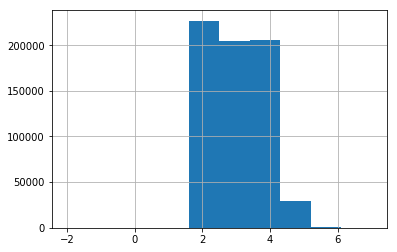

In [83]:
(X_train.sbytes+0.01).apply(np.log10).hist()

# Multi-class Classification
As a 

In [96]:
# Load train and test data
X_train_mc, y_train_mc = dp.load_agg_Xy(path='./data/', sample_size=0.35, strat_cat='attack_cat')

# Creating numeric class labels and reserving holdout
y_train_mc = y_train_mc.apply(lambda x:dp.attack_to_num[x])

X_train_mc, X_holdout_mc, y_train_mc, y_holdout_mc = train_test_split(X_train_mc, y_train_mc,
                                            test_size=0.25, stratify=y_train_mc)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3265: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3265: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


The next two blocks of code quickly try out several classifiers in an attempt to identify 

In [104]:
# Provide classifiers to test for a "first pass" assessment using only vanilla models
mc_classifiers = {
    'knn': KNeighborsClassifier,
    'gnb': GaussianNB,
    'dtc': DecisionTreeClassifier,
    'rfc': RandomForestClassifier,
    'gbc': GradientBoostingClassifier
}

mc_parameters = {
    'knn': {'n_neighbors':9},
    'gnb': {},
    'dtc': {'random_state':0},
    'rfc': {'random_state':0,'n_estimators':100},
    'gbc': {'random_state':0}
}

In [105]:
scores_mc = moda.cross_val_models(mc_classifiers,
                                  ct.fit_transform(X_train_mc),
                                  y_train_mc,use_cv=skf,
                                  params=mc_parameters,
                                  metric='f1_weighted',
                                 verbose=True)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-s

Model: knn Metric: f1_weighted 0.9736719260079921
Model: gnb Metric: f1_weighted 0.8763110028814388


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Model: dtc Metric: f1_weighted 0.9771683628563779


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Model: rfc Metric: f1_weighted 0.9789895184832463


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Model: gbc Metric: f1_weighted 0.9754421421117933


In [163]:
# Train Random Forest Classifier for a multiclass problem
rfc = RandomForestClassifier(n_estimators=150, random_state=0)
rfc.fit(ct.fit_transform(X_train_mc),y_train_mc)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [164]:
# Indexes: true, Columns: predicted
pred_holdout_mc = confusion_matrix(y_holdout_mc, rfc.predict(ct.fit_transform(X_holdout_mc)))

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [165]:
conf_mat = pd.DataFrame(pred_holdout_mc, columns = dp.attack_to_num.items(), index=dp.attack_to_num.items())
conf_mat.head(10)

,,normal,analysis,backdoors,dos,exploits,fuzzers,generic,reconnaissance,shellcode,worms
,,0,1,2,3,4,5,6,7,8,9
normal,0,193596,4,1,2,368,168,2,0,2,0
analysis,1,42,3,0,39,136,14,0,0,0,0
backdoors,2,36,0,8,33,113,13,1,0,0,0
dos,3,262,0,0,147,973,15,28,3,3,0
exploits,4,446,0,3,202,3037,36,163,7,2,0
fuzzers,5,1326,0,1,54,184,554,0,2,0,0
generic,6,63,2,0,21,289,11,18464,2,3,0
reconnaissance,7,484,0,0,21,285,4,1,429,0,0
shellcode,8,67,0,0,1,17,0,0,3,44,0


In [162]:
# I want to take each column and divide it, element-wise, by the value counts for that cyberattack in the dataset.
# Each row of the resulting dataframe should sum to one. Below does not accomplish this.
(conf_mat / conf_mat.sum(axis=1)).round(decimals=3)

,,normal,analysis,backdoors,dos,exploits,fuzzers,generic,reconnaissance,shellcode,worms
,,0,1,2,3,4,5,6,7,8,9
normal,0,0.997,0.021,0.005,0.001,0.087,0.078,0.000,0.000,0.015,0.0
analysis,1,0.000,0.017,0.000,0.023,0.036,0.007,0.000,0.000,0.000,0.0
backdoors,2,0.000,0.000,0.044,0.022,0.029,0.006,0.000,0.000,0.000,0.0
dos,3,0.001,0.000,0.000,0.123,0.251,0.007,0.001,0.002,0.030,0.0
exploits,4,0.002,0.000,0.010,0.167,0.778,0.016,0.008,0.007,0.030,0.0
fuzzers,5,0.007,0.000,0.005,0.041,0.044,0.250,0.000,0.001,0.008,0.0
generic,6,0.000,0.017,0.000,0.017,0.069,0.004,0.979,0.001,0.030,0.0
reconnaissance,7,0.003,0.000,0.000,0.020,0.073,0.002,0.000,0.337,0.000,0.0
shellcode,8,0.000,0.000,0.000,0.003,0.003,0.000,0.000,0.002,0.311,0.0


### conf_mat.normal.divide(conf_mat.sum(axis=1), level=0)